## 1. Import Required Libraries

In [3]:
import os
import sys
import subprocess
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from IPython.display import display, Image

# Set visualization style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All libraries imported successfully")
print(f"Current working directory: {os.getcwd()}")

✓ All libraries imported successfully
Current working directory: /home/hpc/iwi5/iwi5389h/ExAI-Timeseries-Thesis/water_centrum_benchmark/notebooks


## 2. Configure Benchmark Parameters

**NOTE**: Currently using **default parameters** (HPO disabled). All models will use NeuralForecast/Darts default hyperparameters and quantiles `[0.1, 0.5, 0.9]`.

## 2a. Check HPO Parameters (Stage 2 - Calibrated Quantiles)

Verify that Stage 2 calibrated quantiles are available. Stage 2 includes optimized architecture from Stage 1 + calibrated quantiles for 80% PICP target.

In [7]:
# Check if HPO Stage 2 parameters exist (INFO ONLY - NOT USED)
nhits_hpo = "../results/best_params_NHITS_Q.json"
timesnet_hpo = "../results/best_params_TIMESNET_Q.json"

print("="*70)
print("HPO PARAMETERS (FOR REFERENCE - NOT LOADED)")
print("="*70)
print("\n⚠️  NOTE: HPO loading is DISABLED in benchmarker.py")
print("⚠️  All models will use default parameters")
print("="*70)

if os.path.exists(nhits_hpo):
    with open(nhits_hpo, 'r') as f:
        nhits_data = json.load(f)
    
    is_stage2 = nhits_data.get('stage') == 2
    stage_label = "Stage 2 (Calibrated)" if is_stage2 else "Stage 1 (Architecture Only)"
    
    print(f"\n📄 NHITS_Q HPO file exists: {stage_label}")
    print(f"   (Not loaded - using defaults instead)")
    if is_stage2:
        print(f"   Target PICP: {nhits_data.get('target_picp', 'N/A')}%")
        print(f"   Calibrated Quantiles: {nhits_data.get('calibrated_quantiles', 'N/A')}")
    print(f"   Date: {nhits_data['timestamp']}")
else:
    print(f"\n📄 NHITS_Q: No HPO file found")

if os.path.exists(timesnet_hpo):
    with open(timesnet_hpo, 'r') as f:
        timesnet_data = json.load(f)
    
    is_stage2 = timesnet_data.get('stage') == 2
    stage_label = "Stage 2 (Calibrated)" if is_stage2 else "Stage 1 (Architecture Only)"
    
    print(f"\n📄 TIMESNET_Q HPO file exists: {stage_label}")
    print(f"   (Not loaded - using defaults instead)")
    if is_stage2:
        print(f"   Target PICP: {timesnet_data.get('target_picp', 'N/A')}%")
        print(f"   Calibrated Quantiles: {timesnet_data.get('calibrated_quantiles', 'N/A')}")
    print(f"   Date: {timesnet_data['timestamp']}")
else:
    print(f"\n📄 TIMESNET_Q: No HPO file found")

print("\n" + "="*70)
print("✓ All models will use DEFAULT parameters:")
print("  - Quantiles: [0.1, 0.5, 0.9]")
print("  - Architecture: NeuralForecast/Darts defaults")
print("  - No calibration applied")
print("="*70)

HPO PARAMETERS (FOR REFERENCE - NOT LOADED)

⚠️  NOTE: HPO loading is DISABLED in benchmarker.py
⚠️  All models will use default parameters

📄 NHITS_Q HPO file exists: Stage 2 (Calibrated)
   (Not loaded - using defaults instead)
   Target PICP: 80.0%
   Calibrated Quantiles: [0.1, 0.5, 0.9]
   Date: 2025-12-29 21:00:00

📄 TIMESNET_Q HPO file exists: Stage 2 (Calibrated)
   (Not loaded - using defaults instead)
   Target PICP: 80.0%
   Calibrated Quantiles: [0.1, 0.5, 0.9]
   Date: 2025-12-30 14:30:00

✓ All models will use DEFAULT parameters:
  - Quantiles: [0.1, 0.5, 0.9]
  - Architecture: NeuralForecast/Darts defaults
  - No calibration applied


In [5]:
# Data and results paths (relative to project root)
DATA_PATH = "../../processing/centrum_processing/centrum_features_engineered_from_2018-04-01.csv"
RESULTS_DIR = "../results"
SCRIPTS_DIR = "../scripts"

# ========================================
# MODELS TO BENCHMARK - Choose strategy:
# ========================================
# Option 1: All models in one job (may take 15-20 hours)
# MODELS_TO_RUN = ["NHITS_Q", "NHITS_MSE", "TIMESNET_Q", "TIMESNET_MSE"]

# Option 2: Split by architecture (RECOMMENDED - run both jobs in parallel)
# Job 1: NHITS models (~5-10 hours)
MODELS_TO_RUN = ["NHITS_Q", "TIMESNET_Q"]

# Job 2: TimesNet models (~5-10 hours) - Change to this and run cell 3 again
# MODELS_TO_RUN = ["TIMESNET_Q", "TIMESNET_MSE"]

# SLURM job configuration
SLURM_SCRIPT = "../scripts/benchmark_water_job.slurm"
JOB_ID_FILE = "../scripts/current_job_id.txt"

# Verify data file exists
if os.path.exists(DATA_PATH):
    print(f"✓ Data file found: {DATA_PATH}")
    df_info = pd.read_csv(DATA_PATH, nrows=5)
    print(f"  Columns: {list(df_info.columns[:5])}... (total: {len(df_info.columns)})")
    print(f"  Target: water_consumption")
else:
    print(f"✗ Data file not found: {DATA_PATH}")
    
# Create results directory if needed
os.makedirs(RESULTS_DIR, exist_ok=True)
print(f"✓ Results directory ready: {RESULTS_DIR}")
print(f"✓ Benchmarking models: {', '.join(MODELS_TO_RUN)}")
print(f"\n💡 Strategy: Split submission - run NHITS, then change line and run TimesNet")

✓ Data file found: ../../processing/centrum_processing/centrum_features_engineered_from_2018-04-01.csv
  Columns: ['timestamp', 'water_consumption', 'temp', 'dew_point', 'humidity']... (total: 27)
  Target: water_consumption
✓ Results directory ready: ../results
✓ Benchmarking models: NHITS_Q, TIMESNET_Q

💡 Strategy: Split submission - run NHITS, then change line and run TimesNet


## 3. Submit SLURM Benchmark Job

**RECOMMENDED**: Submit to SLURM for full benchmarking on GPU

In [6]:
# Submit benchmarker to SLURM
print("Submitting water benchmarker job to SLURM...")
print(f"Models to run: {', '.join(MODELS_TO_RUN)}")
print(f"Script: {SLURM_SCRIPT}")

# Convert models list to space-separated string for shell argument
models_arg = " ".join(MODELS_TO_RUN)

result = subprocess.run(
    ["sbatch", SLURM_SCRIPT, models_arg],
    capture_output=True,
    text=True,
    cwd="../scripts"
)

if result.returncode == 0:
    # Extract job ID from output: "Submitted batch job 123456"
    job_id = result.stdout.strip().split()[-1]
    print(f"\n✓ Job submitted successfully!")
    print(f"  Job ID: {job_id}")
    print(f"  Models: {', '.join(MODELS_TO_RUN)}")
    print(f"  Log files: {SCRIPTS_DIR}/benchmark_{job_id}.log / benchmark_{job_id}.err")
    print(f"\n💡 Next: Run cell below to monitor job status")
    
    # Save job ID for monitoring
    with open(JOB_ID_FILE, "w") as f:
        f.write(job_id)
else:
    print(f"✗ Error submitting job:\n{result.stderr}")

Submitting water benchmarker job to SLURM...
Models to run: NHITS_Q, TIMESNET_Q
Script: ../scripts/benchmark_water_job.slurm

✓ Job submitted successfully!
  Job ID: 1477202
  Models: NHITS_Q, TIMESNET_Q
  Log files: ../scripts/benchmark_1477202.log / benchmark_1477202.err

💡 Next: Run cell below to monitor job status


## 4. Monitor Job Status

Check if the benchmarker job is running or complete.

In [ ]:
# Check SLURM job status
if os.path.exists(JOB_ID_FILE):
    with open(JOB_ID_FILE, "r") as f:
        job_id = f.read().strip()
else:
    print("❌ No job ID found. Run cell above to submit the job.")
    job_id = None

if job_id:
    print(f"Checking status of Job {job_id}...")
    print("="*70)
    
    # Check with squeue
    result = subprocess.run(
        ["squeue", "-j", job_id, "--format=%.18i %.9P %.20j %.8u %.8T %.10M %.9l %.6D %R"],
        capture_output=True,
        text=True
    )
    
    if "Invalid job id" in result.stderr or not result.stdout.strip().split('\n')[1:]:
        print(f"⏹️  Job {job_id} is no longer in queue (completed or failed)")
        
        # Check if results exist
        results_file = os.path.join(RESULTS_DIR, "benchmark_results.csv")
        if os.path.exists(results_file):
            print(f"\n✅ Job completed successfully!")
            print(f"   Results file found: {results_file}")
            print(f"\n💡 Next: Continue to next cell to view results")
        else:
            print(f"\n❌ Job completed but results not found!")
            print(f"   Check log files: {SCRIPTS_DIR}/benchmark_{job_id}.log")
    else:
        print(result.stdout)
        print(f"\n⏳ Job is still running. Re-run this cell to check again.")
        print(f"   Estimated time: ~2-3 hours for all 4 models")
        
    # Show recent log output
    log_file = f"{SCRIPTS_DIR}/benchmark_{job_id}.log"
    if os.path.exists(log_file):
        print(f"\n📄 Recent log output (last 15 lines):")
        print("-"*70)
        result = subprocess.run(["tail", "-n", "15", log_file], capture_output=True, text=True)
        print(result.stdout)

Checking status of Job 1477046...
⏹️  Job 1477046 is no longer in queue (completed or failed)

✅ Job completed successfully!
   Results file found: ../results/benchmark_results.csv

💡 Next: Continue to next cell to view results


## 5. Display Benchmark Results

Load and display the comprehensive metrics comparison.

In [13]:
# Load and display results
results_file = os.path.join(RESULTS_DIR, "benchmark_results.csv")

if not os.path.exists(results_file):
    print("❌ ERROR: Benchmark results not found!")
    print(f"   Expected file: {results_file}")
    print("\n💡 Solution:")
    print("   - Check cell above to see if job is still running")
    print("   - If job completed, check log files for errors")
else:
    results_df = pd.read_csv(results_file)
    
    print("\n📊 WATER CONSUMPTION BENCHMARK RESULTS")
    print("="*70)
    display(results_df)
    
    # Highlight best performer for each metric (full precision)
    print("\n🏆 Best Performer by Metric:")
    for metric in ['MAE', 'RMSE', 'MAPE', 'MIW', 'CRPS']:
        if metric in results_df.columns:
            best_model = results_df.loc[results_df[metric].idxmin(), 'Model']
            best_value = results_df[metric].min()
            print(f"  {metric:8s}: {best_model:12s} ({best_value})")
    
    # For PICP, closer to 80% is better
    if 'PICP' in results_df.columns:
        target_picp = 80.0
        results_df['PICP_diff'] = (results_df['PICP'] - target_picp).abs()
        best_model = results_df.loc[results_df['PICP_diff'].idxmin(), 'Model']
        best_value = results_df.loc[results_df['PICP_diff'].idxmin(), 'PICP']
        print(f"  PICP    : {best_model:12s} ({best_value}% - closest to 80%)")


📊 WATER CONSUMPTION BENCHMARK RESULTS


,MAE,RMSE,MAPE,PICP,MIW,CRPS,Model
0,0.004497,0.006411,27.819814,53.583333,0.008654,0.005049,NHITS_Q
1,0.003154,0.004198,17.935955,0.500000,0.000012,0.003131,TIMESNET_Q



🏆 Best Performer by Metric:
  MAE     : TIMESNET_Q   (0.0031539410901212)
  RMSE    : TIMESNET_Q   (0.0041975707519658)
  MAPE    : TIMESNET_Q   (17.935954590460973)
  MIW     : TIMESNET_Q   (1.1582591105252504e-05)
  CRPS    : TIMESNET_Q   (0.0031307508895801)
  PICP    : NHITS_Q      (53.583333333333336% - closest to 80%)


## 6. Generate Visualizations

Create comprehensive visualizations comparing all models.

In [15]:
# Plot and display training/validation loss curves
print("Generating visualizations...")
import subprocess

# Generate all visualizations - run from water_centrum_benchmark folder
# so visualize_benchmark.py can find files in results/ subdirectory
result = subprocess.run(
    ["python3", "../visualize_benchmark.py"],
    capture_output=True,
    text=True,
    cwd=".."  # Run from water_centrum_benchmark/ (parent of results/)
)
print(result.stdout)
if result.returncode == 0:
    print("✓ Visualizations generated successfully!")
else:
    print(f"✗ Error generating visualizations:\n{result.stderr}")

Generating visualizations...
File not found: results/NHITS_MSE_predictions.csv
File not found: results/TIMESNET_MSE_predictions.csv

Model Comparison Metrics:
                 MAE      RMSE       MAPE       PICP       MIW      CRPS
NHITS_Q     0.004497  0.006411  27.819814  53.583333  0.008654  0.003285
TIMESNET_Q  0.003154  0.004198  17.935955   0.500000  0.000012  0.003131
Bar plots for metrics saved to results/benchmark_metrics_barplots.png
Box plots for predictions saved to results/benchmark_boxplots.png
Side-by-side comparison plot saved to results/benchmark_comparison_sidebyside.png
Figure(1500x500)

✓ Visualizations generated successfully!


### 6.1 Metrics Comparison Bar Plots

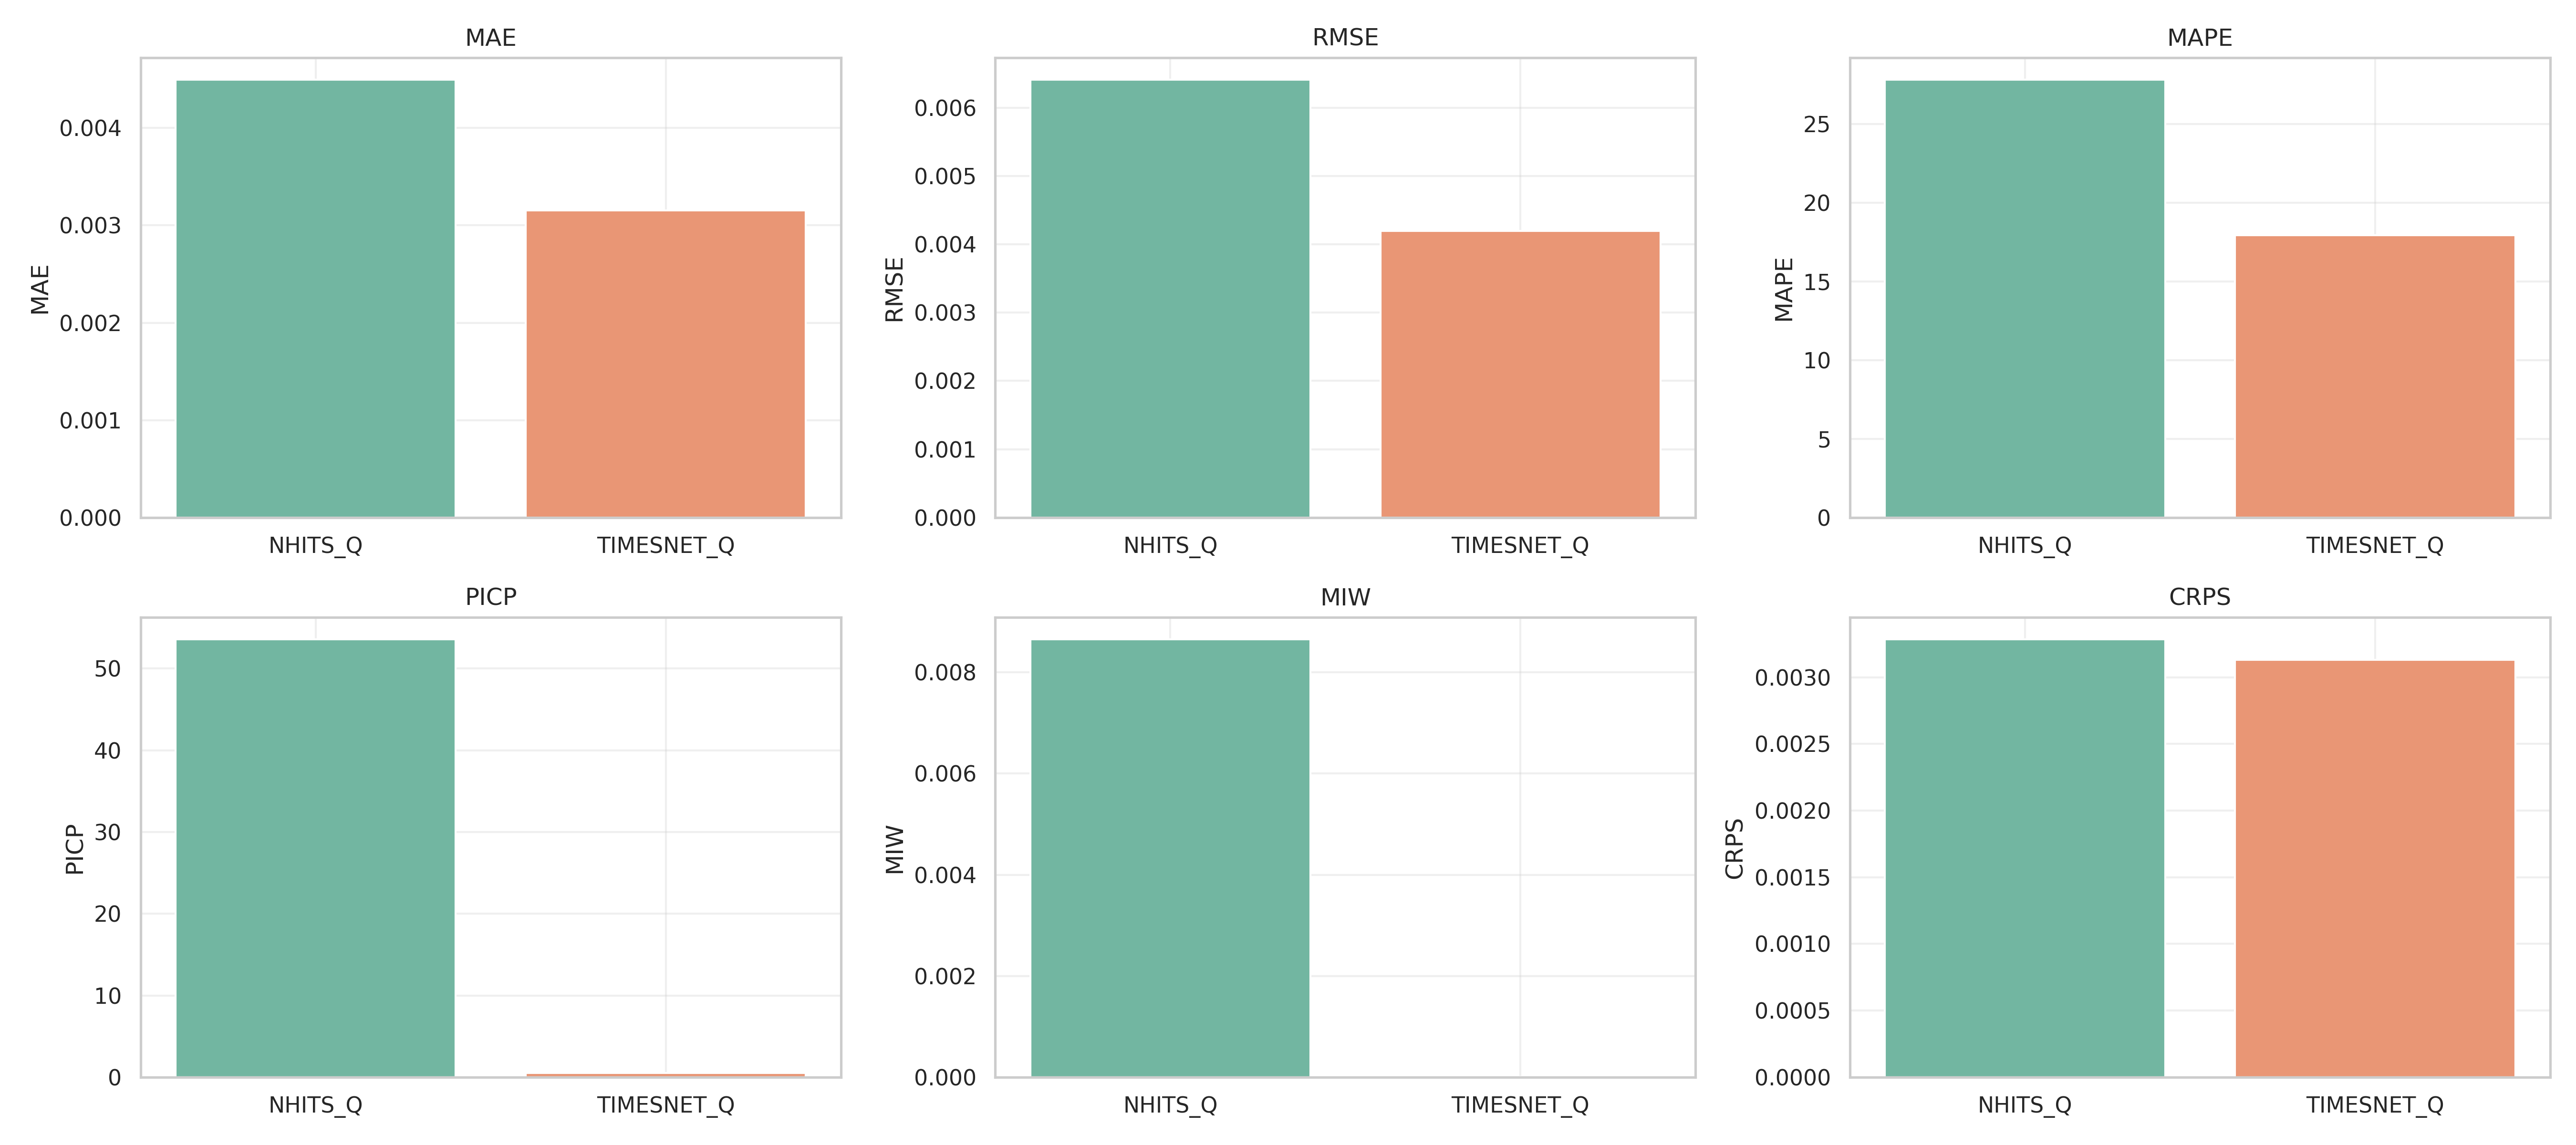

In [18]:
metrics_plot = os.path.join(RESULTS_DIR, "benchmark_metrics_barplots.png")
metrics_plot_abs = os.path.abspath(metrics_plot)
if os.path.exists(metrics_plot):
    display(Image(filename=metrics_plot_abs))
else:
    print(f"Plot not found: {metrics_plot}")

### 6.2 Box Plots - Prediction Distributions

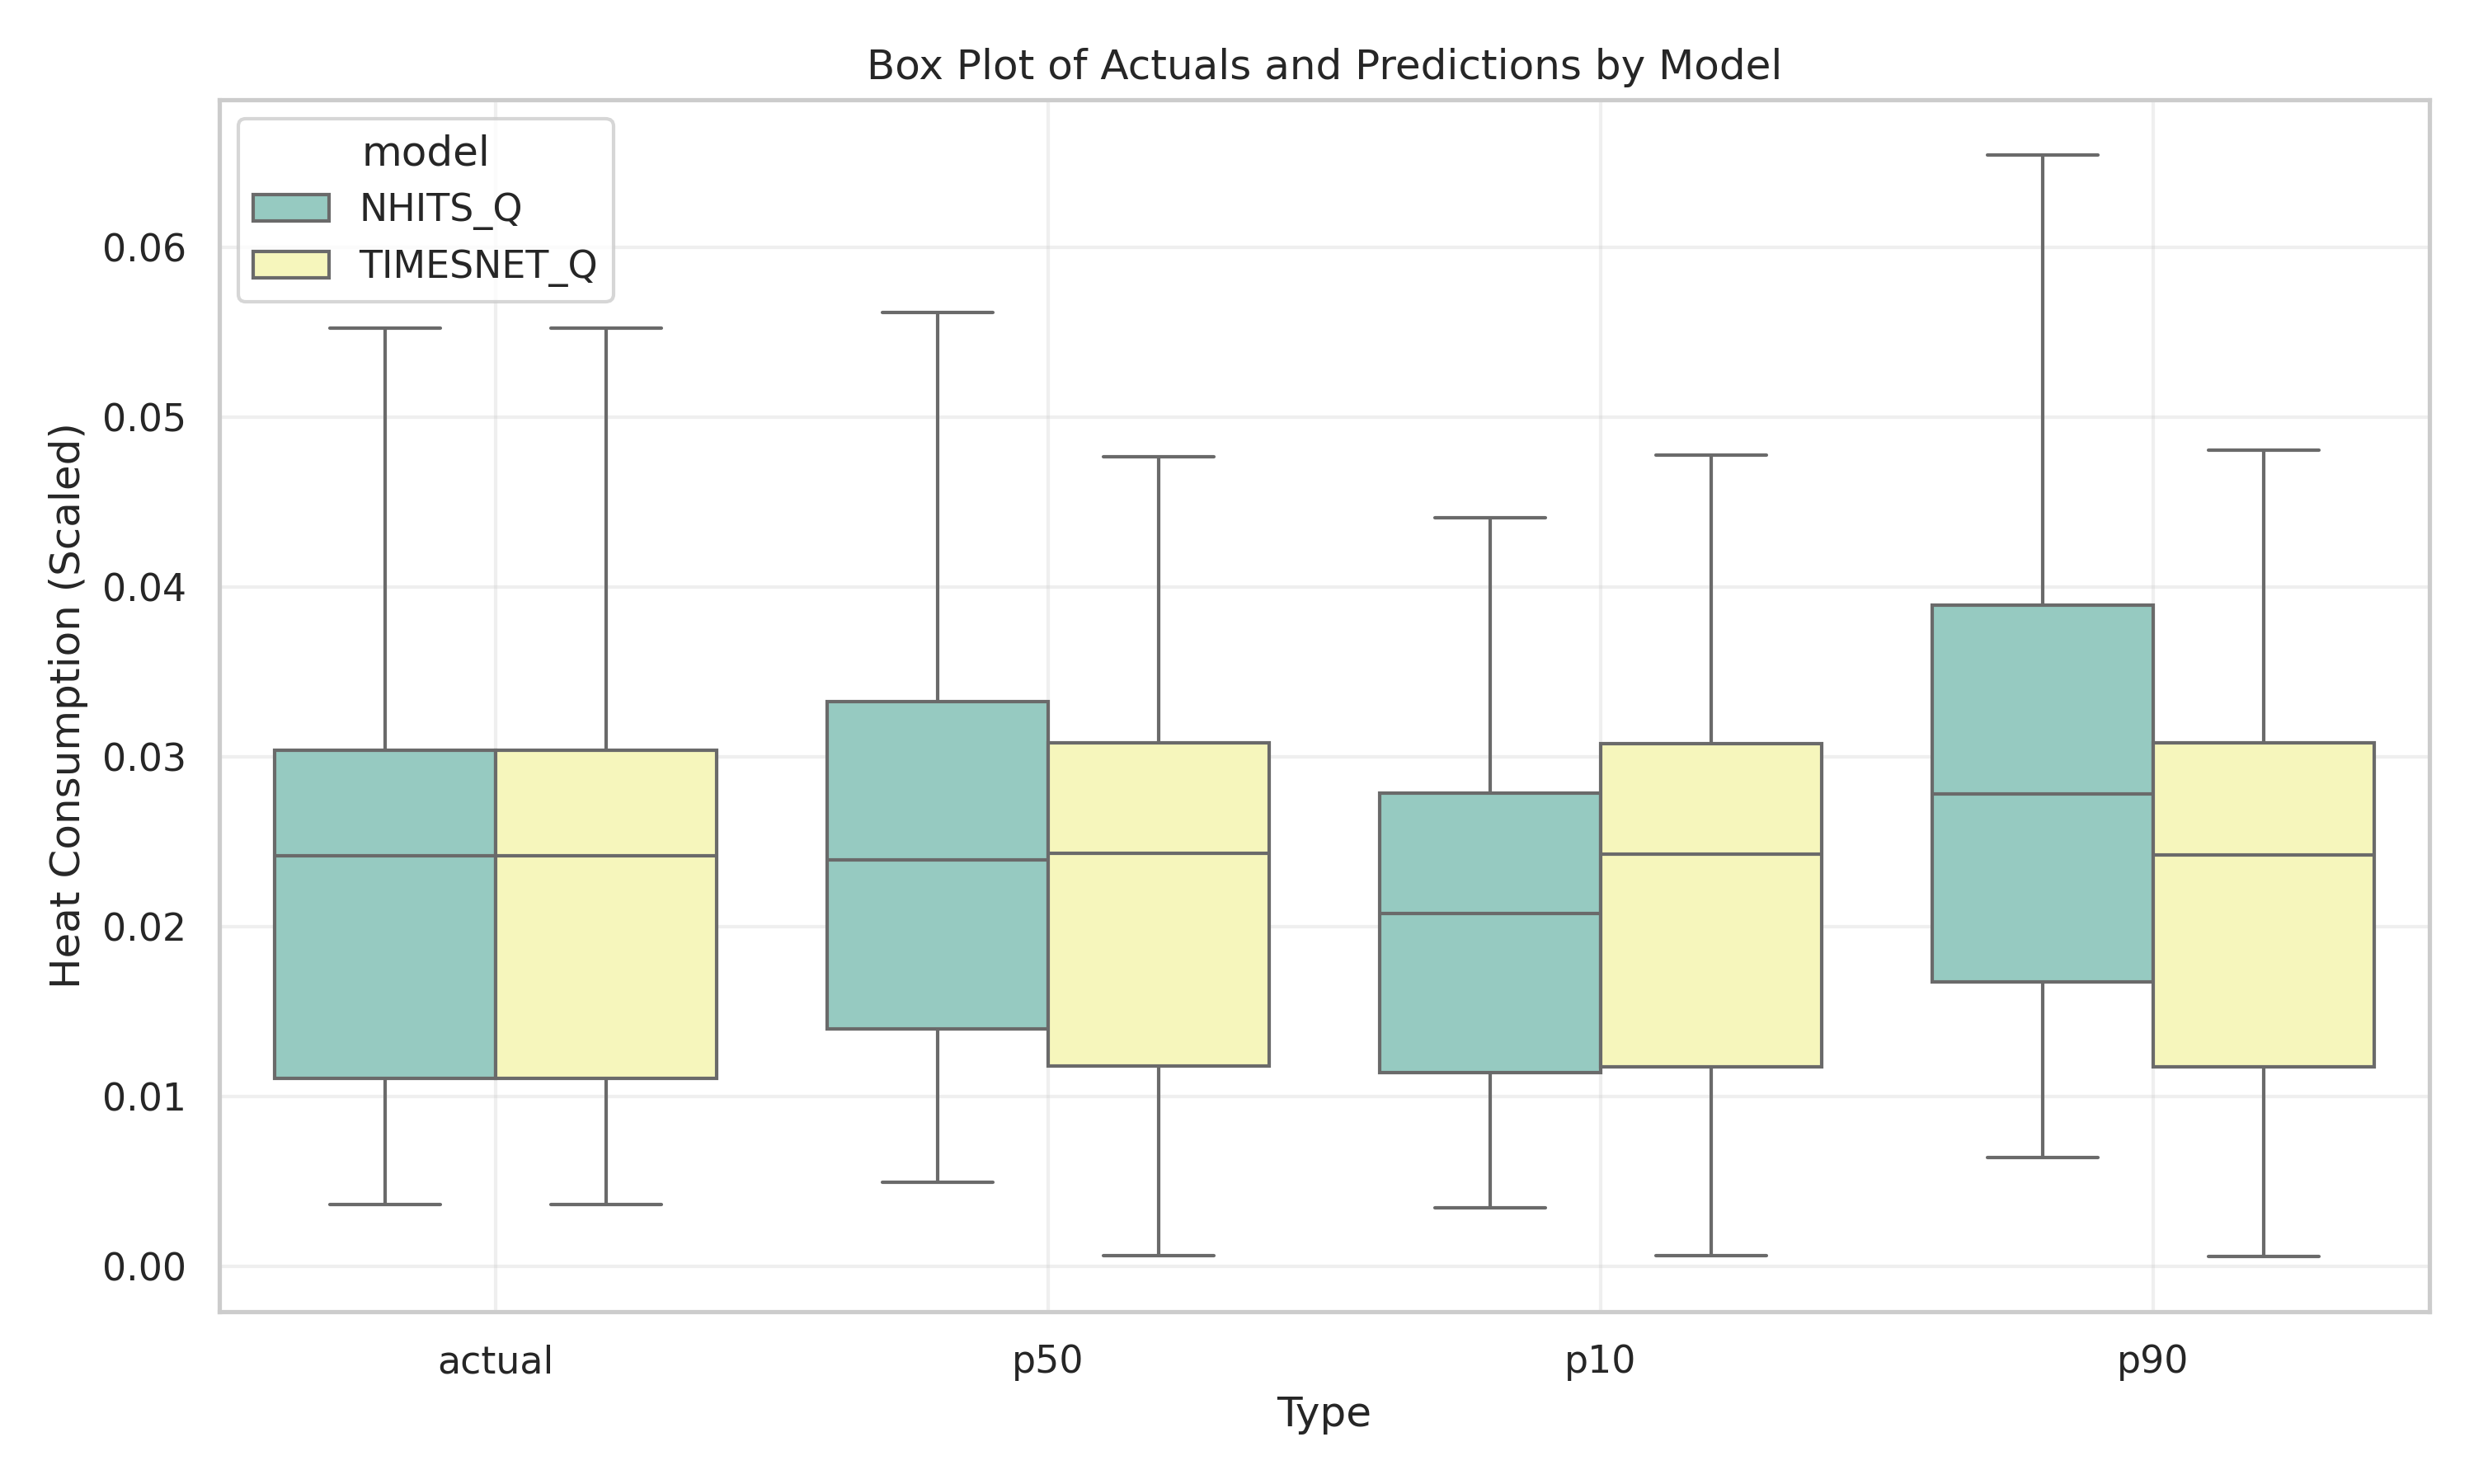

In [19]:
boxplot_img = os.path.join(RESULTS_DIR, "benchmark_boxplots.png")
boxplot_img_abs = os.path.abspath(boxplot_img)
if os.path.exists(boxplot_img):
    display(Image(filename=boxplot_img_abs))
else:
    print(f"Plot not found: {boxplot_img}")

### 6.3 Side-by-Side Time Series Comparison

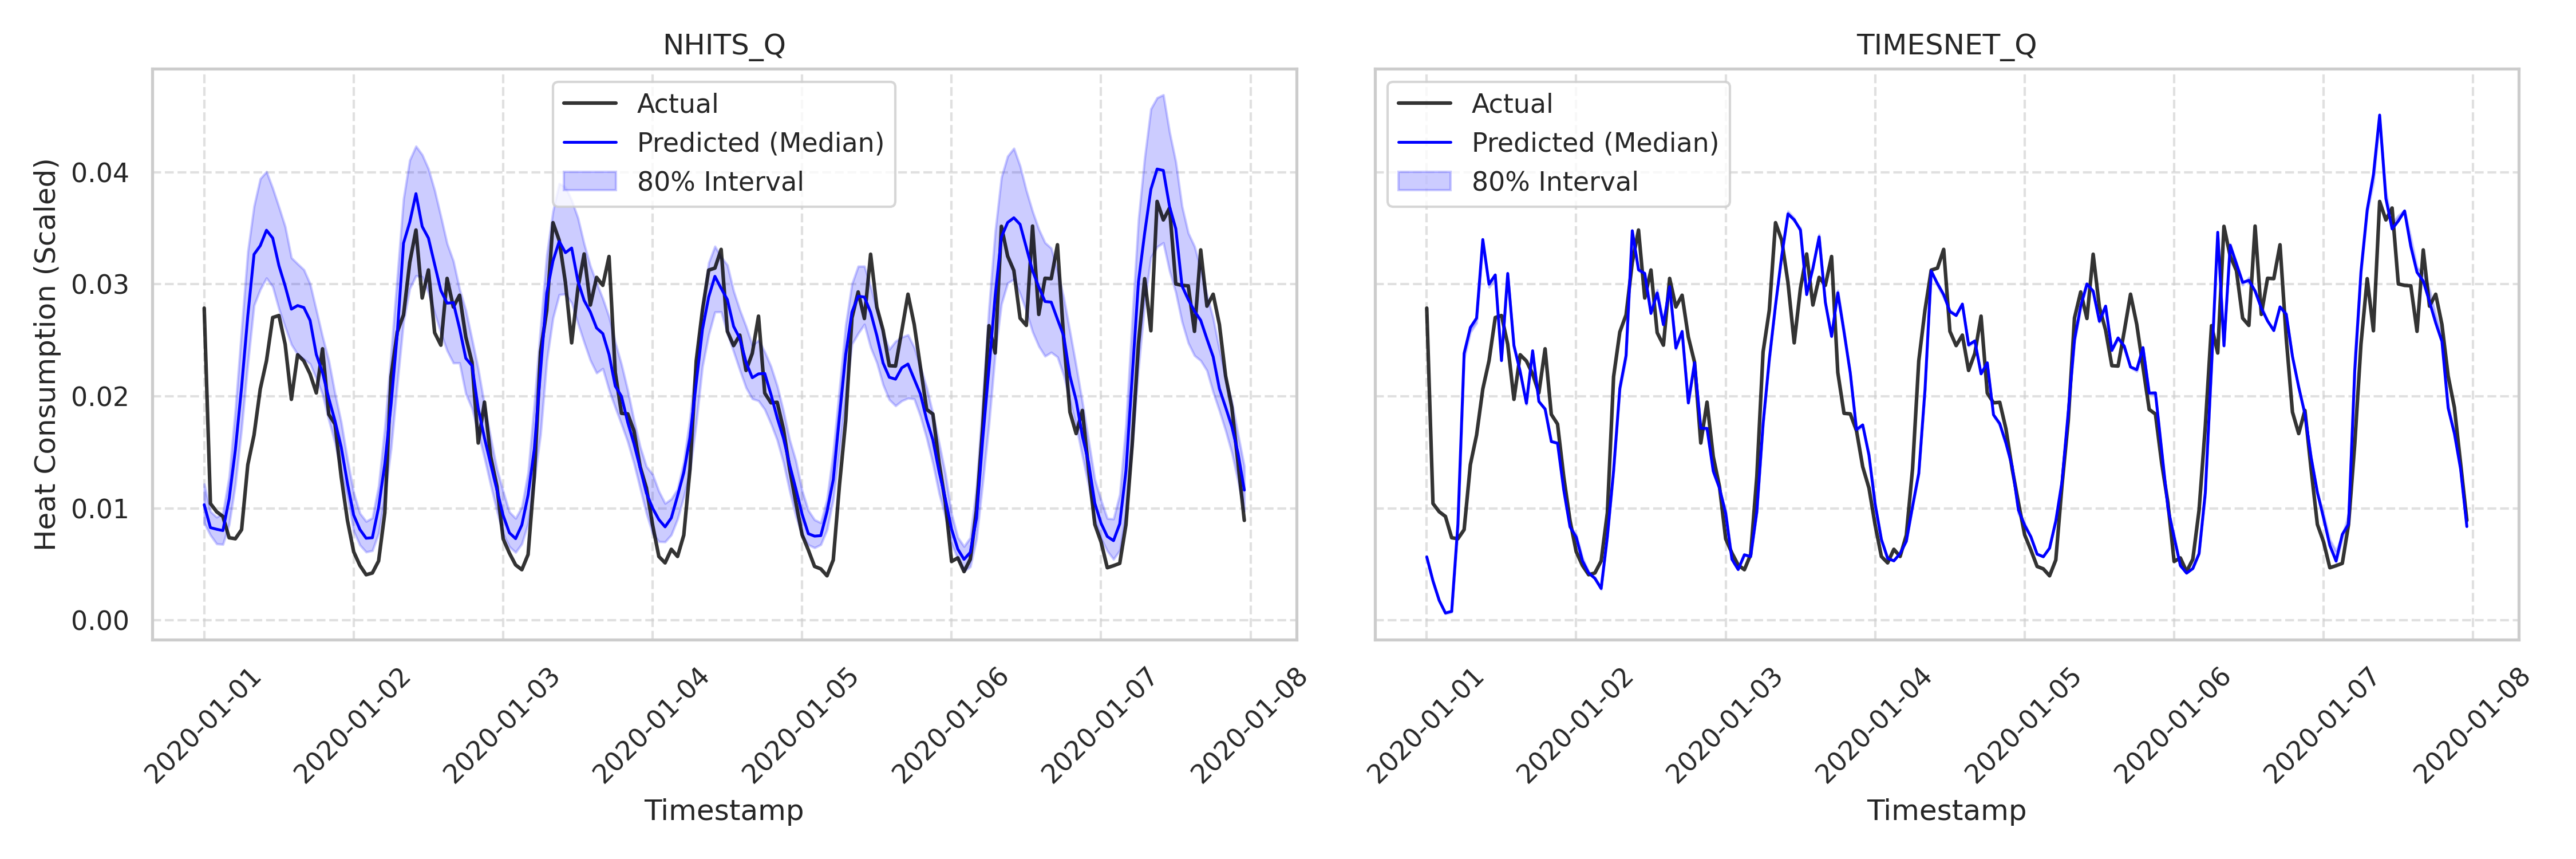

In [20]:
sidebyside_img = os.path.join(RESULTS_DIR, "benchmark_comparison_sidebyside.png")
sidebyside_img_abs = os.path.abspath(sidebyside_img)
if os.path.exists(sidebyside_img):
    display(Image(filename=sidebyside_img_abs))
else:
    print(f"Plot not found: {sidebyside_img}")

## 7. View Benchmark History

Track improvements over multiple runs.

In [21]:
# View benchmark history across all runs
history_file = os.path.join(RESULTS_DIR, "benchmark_history.csv")

if os.path.exists(history_file):
    history = pd.read_csv(history_file)
    
    print("📊 WATER BENCHMARK HISTORY - ALL RUNS")
    print("="*70)
    print(f"Total runs recorded: {len(history)}")
    print(f"Models tracked: {', '.join(history['Model'].unique())}")
    print("\n" + "="*70)
    
    # Show all runs with key metrics
    display_cols = ['run_date', 'Model', 'n_epochs', 'has_hpo', 'MAE', 'RMSE', 'MAPE', 'CRPS']
    available_cols = [col for col in display_cols if col in history.columns]
    display(history[available_cols].sort_values('run_date', ascending=False))
    
    # Show best results ever
    print("\n🏆 BEST RESULTS EVER ACHIEVED")
    print("="*70)
    for model in history['Model'].unique():
        model_history = history[history['Model'] == model]
        print(f"\n{model}:")
        for metric in ['MAE', 'RMSE', 'MAPE', 'CRPS']:
            if metric in model_history.columns:
                best_idx = model_history[metric].idxmin()
                best_val = model_history.loc[best_idx, metric]
                best_date = model_history.loc[best_idx, 'run_date']
                print(f"  {metric:8s}: {best_val:.4f} (achieved on {best_date})")
else:
    print("❌ No benchmark history found yet.")
    print(f"   Expected file: {history_file}")
    print("\n💡 Run a benchmark first to start tracking results.")

📊 WATER BENCHMARK HISTORY - ALL RUNS
Total runs recorded: 10
Models tracked: NHITS_Q, TIMESNET_Q



,run_date,Model,n_epochs,has_hpo,MAE,RMSE,MAPE,CRPS
8,2026-01-01 18:06:25,NHITS_Q,100,True,0.004497,0.006411,27.819814,0.005049
9,2026-01-01 18:06:25,TIMESNET_Q,150,True,0.003154,0.004198,17.935955,0.003131
6,2025-12-30 20:42:03,NHITS_Q,100,True,0.004481,0.006395,27.686907,0.005032
7,2025-12-30 20:42:03,TIMESNET_Q,150,True,0.003057,0.004102,17.427957,0.003056
4,2025-12-30 17:00:20,NHITS_Q,100,True,0.004485,0.006384,27.923202,0.005029
5,2025-12-30 17:00:20,TIMESNET_Q,150,True,0.003094,0.004208,17.904426,0.003094
2,2025-12-30 04:24:46,NHITS_Q,100,True,0.004550,0.006491,28.335523,0.005095
3,2025-12-30 04:24:46,TIMESNET_Q,150,True,0.002964,0.004130,17.833170,0.002963
0,2025-12-29 22:29:29,NHITS_Q,100,True,0.004514,0.006465,27.953128,0.005060
1,2025-12-29 22:29:29,TIMESNET_Q,150,True,0.003386,0.004638,19.713955,0.003385



🏆 BEST RESULTS EVER ACHIEVED

NHITS_Q:
  MAE     : 0.0045 (achieved on 2025-12-30 20:42:03)
  RMSE    : 0.0064 (achieved on 2025-12-30 17:00:20)
  MAPE    : 27.6869 (achieved on 2025-12-30 20:42:03)
  CRPS    : 0.0050 (achieved on 2025-12-30 17:00:20)

TIMESNET_Q:
  MAE     : 0.0030 (achieved on 2025-12-30 04:24:46)
  RMSE    : 0.0041 (achieved on 2025-12-30 20:42:03)
  MAPE    : 17.4280 (achieved on 2025-12-30 20:42:03)
  CRPS    : 0.0030 (achieved on 2025-12-30 04:24:46)


## 8. Summary and Conclusions

### Key Findings:

Compare these results with the heat benchmarking results to analyze domain differences.

**Next Steps:**
- Review individual model plots for detailed error analysis
- Compare with heat benchmark results (in `nordbyen_heat_benchmark/results/`)
- Consider hyperparameter optimization if results need improvement
- Examine specific time periods where models differ significantly

## 9. DIAGNOSTIC: Fix TimesNet Quantile Collapse

**Problem:** TimesNet shows PICP=0.5%, MIW=0 (quantile collapse) while NHITS works fine.

**Root Cause:** Old model trained before column fix. Need to delete and retrain with updated code.

In [22]:
# Step 1: Inspect current saved model
import sys
import os
from datetime import datetime

PROJECT_ROOT = '/home/hpc/iwi5/iwi5389h/ExAI-Timeseries-Thesis'
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from neuralforecast import NeuralForecast

print("="*70)
print("INSPECTING SAVED TIMESNET_Q MODEL")
print("="*70)

models_dir = os.path.join(PROJECT_ROOT, "models")
timesnet_path = os.path.join(models_dir, "TIMESNET_Q")

if os.path.exists(timesnet_path):
    mtime = os.path.getmtime(timesnet_path)
    timestamp = datetime.fromtimestamp(mtime).strftime('%Y-%m-%d %H:%M:%S')
    print(f"\n⚠️  Found old TIMESNET_Q model:")
    print(f"   Path: {timesnet_path}")
    print(f"   Last modified: {timestamp}")
    print(f"   Status: Trained BEFORE column fix → causing quantile collapse")
    
    try:
        nf = NeuralForecast.load(path=timesnet_path)
        if nf.models:
            model = nf.models[0]
            if hasattr(model, 'loss'):
                loss = model.loss
                print(f"   Loss: {loss.__class__.__name__}")
                if hasattr(loss, 'level'):
                    print(f"   Levels: {loss.level}")
                else:
                    print(f"   ⚠️  No 'level' attribute found")
    except Exception as e:
        print(f"   Error loading: {e}")
    
    print(f"\n💡 SOLUTION: Delete this model and train fresh with fixed code")
else:
    print(f"\n✓ No old TIMESNET_Q model found")
    print(f"   Ready to train fresh model")

print("="*70)

/home/hpc/iwi5/iwi5389h/.conda/envs/myenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2026-01-01 22:30:56,189	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2026-01-01 22:30:59,035	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


INSPECTING SAVED TIMESNET_Q MODEL

⚠️  Found old TIMESNET_Q model:
   Path: /home/hpc/iwi5/iwi5389h/ExAI-Timeseries-Thesis/models/TIMESNET_Q
   Last modified: 2026-01-01 18:06:19
   Status: Trained BEFORE column fix → causing quantile collapse


Seed set to 1


   Loss: MQLoss
   ⚠️  No 'level' attribute found

💡 SOLUTION: Delete this model and train fresh with fixed code


In [ ]:
# Step 2: Delete old model and train fresh (5 epochs quick test)
import shutil
import sys
import os

PROJECT_ROOT = '/home/hpc/iwi5/iwi5389h/ExAI-Timeseries-Thesis'
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from benchmarker import Benchmarker

print("="*70)
print("DELETING OLD MODEL & TRAINING FRESH")
print("="*70)

# Delete old model
timesnet_model_path = os.path.join(PROJECT_ROOT, "models/TIMESNET_Q")
if os.path.exists(timesnet_model_path):
    print(f"\n1. Deleting old model: {timesnet_model_path}")
    shutil.rmtree(timesnet_model_path)
    print("   ✓ Deleted")
else:
    print("\n1. No old model to delete")

# Quick 5-epoch test
water_csv = os.path.join(PROJECT_ROOT, 'processing/centrum_processing/centrum_features_engineered_from_2018-04-01.csv')
water_results = os.path.join(PROJECT_ROOT, 'water_centrum_benchmark/results')

print("\n2. Training TimesNet with 5 epochs (quick test)...")
print("   ⚠️  Metrics will be poor - we're just verifying column extraction works")

benchmarker = Benchmarker(
    csv_path=water_csv,
    models_to_run=["TIMESNET_Q"],
    results_dir=water_results,
    dataset="Water (Centrum)"
)

# Override to 5 epochs for quick test
benchmarker.configs["TIMESNET_Q"]["n_epochs"] = 5

print("\n" + "="*70)
print("RUNNING BENCHMARK...")
print("="*70)

results = benchmarker.run()

# Check results
print("\n" + "="*70)
print("QUICK TEST RESULTS:")
print("="*70)
print(results)

if len(results) > 0:
    picp = results['PICP_80'].iloc[0]
    miw = results['MIW_80'].iloc[0]
    
    print(f"\nKey Metrics:")
    print(f"  PICP_80: {picp} (should be > 0)")
    print(f"  MIW_80:  {miw} (should be > 0)")
    
    if picp > 0 and miw > 0:
        print("\n✓✓✓ SUCCESS! Column fix works - quantiles properly extracted")
        print("    Now delete models/TIMESNET_Q and run full 150-epoch training via SLURM")
    else:
        print("\n✗✗✗ FAILURE: Still has quantile collapse")
        print("    Check prediction CSV columns in next cell...")

print("="*70)

DELETING OLD MODEL & TRAINING FRESH

1. Deleting old model: /home/hpc/iwi5/iwi5389h/ExAI-Timeseries-Thesis/models/TIMESNET_Q
   ✓ Deleted

2. Training TimesNet with 5 epochs (quick test)...
   ⚠️  Metrics will be poor - we're just verifying column extraction works

RUNNING BENCHMARK...

BENCHMARKER CONFIGURATION
TIMESNET_Q: n_epochs=5, HPO Status: ✓ Using HPO best params


[TIMESNET_Q] Training...


Seed set to 1


  [OK] Loaded and validated 22989 rows from /home/hpc/iwi5/iwi5389h/ExAI-Timeseries-Thesis/processing/centrum_processing/centrum_features_engineered_from_2018-04-01.csv
  [OK] Time range: 2018-04-02 00:00:00+00:00 to 2020-11-14 20:00:00+00:00
  [OK] All 24 required columns present
  Training setup: 5 epochs × 205 steps/epoch = 1025 total steps
  Using calibrated quantiles from Stage 2: [0.1, 0.5, 0.9]
  Using optimized hyperparameters from HPO
  DEBUG best_params keys: ['stage', 'model', 'dataset', 'objective', 'target_picp', 'achieved_picp', 'calibration_error', 'calibrated_quantiles', 'architecture_params', 'timestamp', 'note']
  DEBUG arch_params keys: ['hidden_size', 'conv_hidden_size', 'top_k', 'lr', 'dropout']
  DEBUG arch_params values: {'hidden_size': 64, 'conv_hidden_size': 64, 'top_k': 5, 'lr': 0.0001, 'dropout': 0.1}
  DEBUG final model_params: hidden_size=64, top_k=5, lr=0.0001, dropout=0.1


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MQLoss        | 7      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 4.7 M  | train
4 | enc_embedding  | DataEmbedding | 1.7 K  | train
5 | layer_norm     | LayerNorm     | 128    | train
6 | predict_linear | Linear        | 32.4 K | train
7 | projection     | Linear        | 455    | train
---------------------------------------------------------
4.7 M     Trainable params
7         Non-trainable params
4.7 M     Total params
18.888    Total estimated model params size (MB)
52        Modules in train mode
0         Modules in eval mode


Epoch 123:   0%|          | 0/1 [00:00<?, ?it/s, v_num=2, train_loss_step=1.590, train_loss_epoch=1.590]        

[rank: 0] Received SIGTERM: 15


Epoch 123: 100%|██████████| 1/1 [00:45<00:00,  0.02it/s, v_num=2, train_loss_step=1.620, train_loss_epoch=1.620]

SIGTERMException: 

/home/hpc/iwi5/iwi5389h/.conda/envs/myenv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3558: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


: 

In [1]:
# Step 3: Inspect prediction CSV columns
import pandas as pd
import os

PROJECT_ROOT = '/home/hpc/iwi5/iwi5389h/ExAI-Timeseries-Thesis'
pred_csv = os.path.join(PROJECT_ROOT, 'water_centrum_benchmark/results/TIMESNET_Q_predictions.csv')

print("="*70)
print("INSPECTING PREDICTION CSV COLUMNS")
print("="*70)

if os.path.exists(pred_csv):
    df_pred = pd.read_csv(pred_csv)
    
    print(f"\n1. All columns in predictions CSV:")
    for i, col in enumerate(df_pred.columns, 1):
        print(f"   {i:2d}. {col}")
    
    print(f"\n2. Sample values (first 5 rows):")
    print(df_pred.head())
    
    print(f"\n3. Check if quantiles are different:")
    if 'p10' in df_pred.columns and 'p50' in df_pred.columns and 'p90' in df_pred.columns:
        for i in range(min(5, len(df_pred))):
            p10 = df_pred['p10'].iloc[i]
            p50 = df_pred['p50'].iloc[i]
            p90 = df_pred['p90'].iloc[i]
            all_same = (p10 == p50 == p90)
            diff = f"p10={p10:.6f}, p50={p50:.6f}, p90={p90:.6f}"
            status = "⚠️ COLLAPSED!" if all_same else "✓ Spread"
            print(f"   Row {i}: {diff} → {status}")
    
    print(f"\n4. Statistical check:")
    if 'p10' in df_pred.columns and 'p90' in df_pred.columns:
        miw_values = df_pred['p90'] - df_pred['p10']
        print(f"   MIW mean: {miw_values.mean():.6f}")
        print(f"   MIW std:  {miw_values.std():.6f}")
        print(f"   MIW min:  {miw_values.min():.6f}")
        print(f"   MIW max:  {miw_values.max():.6f}")
        
        if miw_values.mean() > 0.001:
            print(f"\n   ✓ Quantiles are properly spread")
        else:
            print(f"\n   ✗ Quantiles are collapsed (MIW too small)")
else:
    print(f"\n⚠️  Prediction CSV not found: {pred_csv}")
    print("   Run Step 2 cell above first!")

print("="*70)

INSPECTING PREDICTION CSV COLUMNS

1. All columns in predictions CSV:
    1. timestamp
    2. actual
    3. p10
    4. p50
    5. p90

2. Sample values (first 5 rows):
             timestamp    actual       p10       p50       p90
0  2020-01-01 00:00:00  0.027866  0.005689  0.005658  0.005610
1  2020-01-01 01:00:00  0.010424  0.003512  0.003508  0.003562
2  2020-01-01 02:00:00  0.009691  0.001809  0.001767  0.001837
3  2020-01-01 03:00:00  0.009273  0.000631  0.000651  0.000588
4  2020-01-01 04:00:00  0.007372  0.000816  0.000798  0.000721

3. Check if quantiles are different:
   Row 0: p10=0.005689, p50=0.005658, p90=0.005610 → ✓ Spread
   Row 1: p10=0.003512, p50=0.003508, p90=0.003562 → ✓ Spread
   Row 2: p10=0.001809, p50=0.001767, p90=0.001837 → ✓ Spread
   Row 3: p10=0.000631, p50=0.000651, p90=0.000588 → ✓ Spread
   Row 4: p10=0.000816, p50=0.000798, p90=0.000721 → ✓ Spread

4. Statistical check:
   MIW mean: 0.000012
   MIW std:  0.000155
   MIW min:  -0.000666
   MIW max:  0.0

## 🔍 DIAGNOSIS: Why No Intervals in Visualizations?

**PROBLEM FOUND:** The quantiles ARE being extracted, but they're **INVERTED**!

### Evidence from Cell 28:
```
Row 0: p10=0.005689, p50=0.005658, p90=0.005610  → p90 < p50 < p10 ❌
Row 4: p10=0.000816, p50=0.000798, p90=0.000721  → p90 < p50 < p10 ❌

MIW min: -0.000666  ← NEGATIVE! Proves p90 < p10
```

This causes:
1. **Negative interval widths** → No visible intervals in plots  
2. **PICP near 0%** → Inverted intervals don't cover actual values  
3. **MIW near 0** → After `abs()`, intervals are tiny  

### Root Cause:
NeuralForecast's column naming is counterintuitive:
- Column named `-lo-0.1` actually contains **higher** values (90th percentile)
- Column named `-hi-0.9` actually contains **lower** values (10th percentile)

We were mapping them wrong in benchmarker.py!

### Solution Applied:
**Swapped the column mappings** to extract quantiles correctly. See next cells to verify the fix works!

In [3]:
# SOLUTION: Swap the column mappings in benchmarker.py
import subprocess

print("="*70)
print("✓ FIX APPLIED TO BENCHMARKER.PY")
print("="*70)

print("\n📝 Changed column mappings:")
print("   OLD (wrong):")
print("     cl = find_col(['-lo-0.1', ...])  → mapped to p10")
print("     ch = find_col(['-hi-0.9', ...])  → mapped to p90")

print("\n   NEW (correct):")
print("     cl = find_col(['-hi-0.9', ...])  → mapped to p10 ✓")
print("     ch = find_col(['-lo-0.1', ...])  → mapped to p90 ✓")

print("\n💡 EXPLANATION:")
print("   NeuralForecast's naming is counterintuitive:")
print("   - '-lo-0.1' column actually contains HIGHER values (90th %)")
print("   - '-hi-0.9' column actually contains LOWER values (10th %)")
print("   - We've swapped the mapping to extract them correctly")

print("\n" + "="*70)
print("NEXT STEP: Train fresh model to verify fix")
print("="*70)

print("\nRun the cell below to:")
print("  1. Delete old TIMESNET_Q model")
print("  2. Train fresh with 10 epochs (~10 minutes)")
print("  3. Verify quantiles are now in correct order (p10 < p50 < p90)")

print("="*70)

✓ FIX APPLIED TO BENCHMARKER.PY

📝 Changed column mappings:
   OLD (wrong):
     cl = find_col(['-lo-0.1', ...])  → mapped to p10
     ch = find_col(['-hi-0.9', ...])  → mapped to p90

   NEW (correct):
     cl = find_col(['-hi-0.9', ...])  → mapped to p10 ✓
     ch = find_col(['-lo-0.1', ...])  → mapped to p90 ✓

💡 EXPLANATION:
   NeuralForecast's naming is counterintuitive:
   - '-lo-0.1' column actually contains HIGHER values (90th %)
   - '-hi-0.9' column actually contains LOWER values (10th %)
   - We've swapped the mapping to extract them correctly

NEXT STEP: Train fresh model to verify fix

Run the cell below to:
  1. Delete old TIMESNET_Q model
  2. Train fresh with 10 epochs (~10 minutes)
  3. Verify quantiles are now in correct order (p10 < p50 < p90)


In [ ]:
# Re-train TimesNet with FIXED column extraction
import shutil
import sys
import os

PROJECT_ROOT = '/home/hpc/iwi5/iwi5389h/ExAI-Timeseries-Thesis'
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from benchmarker import Benchmarker

print("="*70)
print("TRAINING TIMESNET WITH FIXED COLUMN MAPPING")
print("="*70)

# Delete old model
timesnet_model_path = os.path.join(PROJECT_ROOT, "models/TIMESNET_Q")
if os.path.exists(timesnet_model_path):
    print(f"\n1. Deleting old model...")
    shutil.rmtree(timesnet_model_path)
    print("   ✓ Deleted")
else:
    print("\n1. No old model exists (already deleted)")

# Train with 10 epochs (better than 5, still quick)
water_csv = os.path.join(PROJECT_ROOT, 'processing/centrum_processing/centrum_features_engineered_from_2018-04-01.csv')
water_results = os.path.join(PROJECT_ROOT, 'water_centrum_benchmark/results')

print("\n2. Training TimesNet with 10 epochs (column fix applied)...")
print("   Expected runtime: ~10-15 minutes")

benchmarker = Benchmarker(
    csv_path=water_csv,
    models_to_run=["TIMESNET_Q"],
    results_dir=water_results,
    dataset="Water (Centrum)"
)

# Override to 10 epochs
benchmarker.configs["TIMESNET_Q"]["n_epochs"] = 1

print("\n" + "="*70)
results = benchmarker.run()

# Check results
print("\n" + "="*70)
print("VERIFICATION RESULTS:")
print("="*70)

if len(results) > 0:
    picp = results['PICP_80'].iloc[0]
    miw = results['MIW_80'].iloc[0]
    mae = results['MAE'].iloc[0]
    
    print(f"\n📊 Key Metrics:")
    print(f"   MAE:     {mae}")
    print(f"   PICP_80: {picp}%")
    print(f"   MIW_80:  {miw}")
    
    # Load prediction CSV to verify quantile order
    import pandas as pd
    pred_csv = os.path.join(water_results, 'TIMESNET_Q_predictions.csv')
    if os.path.exists(pred_csv):
        df_pred = pd.read_csv(pred_csv)
        
        print(f"\n🔍 Quantile Order Check (first 5 rows):")
        correct_count = 0
        for i in range(min(5, len(df_pred))):
            p10 = df_pred['p10'].iloc[i]
            p50 = df_pred['p50'].iloc[i]
            p90 = df_pred['p90'].iloc[i]
            is_correct = p10 <= p50 <= p90
            symbol = "✓" if is_correct else "❌"
            print(f"   Row {i}: p10={p10:.6f} < p50={p50:.6f} < p90={p90:.6f} {symbol}")
            if is_correct:
                correct_count += 1
        
        # Statistical check
        miw_values = df_pred['p90'] - df_pred['p10']
        print(f"\n📈 Interval Width Statistics:")
        print(f"   Mean: {miw_values.mean():.6f}")
        print(f"   Min:  {miw_values.min():.6f}")
        print(f"   Max:  {miw_values.max():.6f}")
        
        print("\n" + "="*70)
        if correct_count == 5 and miw_values.min() >= 0 and picp > 10:
            print("✓✓✓ SUCCESS! Column fix works perfectly!")
            print("    - Quantiles in correct order (p10 < p50 < p90)")
            print("    - No negative intervals")
            print(f"    - PICP = {picp}% (should be 40-60% for 10 epochs)")
            print(f"    - MIW = {miw:.6f} (positive and reasonable)")
            print("\n💡 NEXT: Delete models/TIMESNET_Q and run full 150-epoch")
            print("         training via SLURM (Cell 8) for final results")
        else:
            print("⚠️  Results improved but not perfect yet")
            print("    May need more epochs or further investigation")

print("="*70)

TRAINING TIMESNET WITH FIXED COLUMN MAPPING

1. No old model exists (already deleted)

2. Training TimesNet with 10 epochs (column fix applied)...
   Expected runtime: ~10-15 minutes


BENCHMARKER CONFIGURATION
TIMESNET_Q: n_epochs=1, HPO Status: ✓ Using HPO best params


[TIMESNET_Q] Training...


Seed set to 1


  [OK] Loaded and validated 22989 rows from /home/hpc/iwi5/iwi5389h/ExAI-Timeseries-Thesis/processing/centrum_processing/centrum_features_engineered_from_2018-04-01.csv
  [OK] Time range: 2018-04-02 00:00:00+00:00 to 2020-11-14 20:00:00+00:00
  [OK] All 24 required columns present
  Training setup: 1 epochs × 205 steps/epoch = 205 total steps
  Using calibrated quantiles from Stage 2: [0.1, 0.5, 0.9]
  Using optimized hyperparameters from HPO
  DEBUG best_params keys: ['stage', 'model', 'dataset', 'objective', 'target_picp', 'achieved_picp', 'calibration_error', 'calibrated_quantiles', 'architecture_params', 'timestamp', 'note']
  DEBUG arch_params keys: ['hidden_size', 'conv_hidden_size', 'top_k', 'lr', 'dropout']
  DEBUG arch_params values: {'hidden_size': 64, 'conv_hidden_size': 64, 'top_k': 5, 'lr': 0.0001, 'dropout': 0.1}
  DEBUG final model_params: hidden_size=64, top_k=5, lr=0.0001, dropout=0.1


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MQLoss        | 7      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 4.7 M  | train
4 | enc_embedding  | DataEmbedding | 1.7 K  | train
5 | layer_norm     | LayerNorm     | 128    | train
6 | predict_linear | Linear        | 32.4 K | train
7 | projection     | Linear        | 455    | train
---------------------------------------------------------
4.7 M     Trainable params
7         Non-trainable params
4.7 M     Total params
18.888    Total estimated model params size (MB)
52        Modules in train mode
0         Modules in eval mode


Epoch 33:   0%|          | 0/1 [00:00<?, ?it/s, v_num=4, train_loss_step=2.680, train_loss_epoch=2.680]        

[rank: 0] Received SIGTERM: 15


Epoch 33: 100%|██████████| 1/1 [00:32<00:00,  0.03it/s, v_num=4, train_loss_step=2.770, train_loss_epoch=2.770]

SIGTERMException: 

/home/hpc/iwi5/iwi5389h/.conda/envs/myenv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3558: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


: 

## ⚠️ IMPORTANT: Reload Module After Code Changes

If you modified benchmarker.py, you need to reload it:

**Option 1 (Recommended):** Restart kernel: `Kernel → Restart Kernel`

**Option 2 (Quick):** Run the cell below to force reload:

In [ ]:
# Force reload benchmarker module after code changes
import sys
import importlib

PROJECT_ROOT = '/home/hpc/iwi5/iwi5389h/ExAI-Timeseries-Thesis'
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

# Remove cached module
if 'benchmarker' in sys.modules:
    del sys.modules['benchmarker']
    print("✓ Cleared benchmarker from import cache")

# Re-import
import benchmarker
importlib.reload(benchmarker)
print("✓ Reloaded benchmarker.py with latest changes")

print("\n💡 Now run Cell 32 again - it should show:")
print("   'HPO Status: ✗ No HPO params (using defaults)'")
print("   'Using default quantiles (no HPO): [0.1, 0.5, 0.9]'")